In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta

In [2]:
def nsefetch(payload):
    try:
        output = requests.get(payload,headers=headers).json()
        #print(output)
    except ValueError:
        s =requests.Session()
        output = s.get("http://nseindia.com",headers=headers)
        output = s.get(payload,headers=headers).json()
    return output

In [3]:
headers = {
    'Connection': 'keep-alive',
    'Cache-Control': 'max-age=0',
    'DNT': '1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.79 Safari/537.36',
    'Sec-Fetch-User': '?1',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Sec-Fetch-Site': 'none',
    'Sec-Fetch-Mode': 'navigate',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9,hi;q=0.8',
}

In [4]:
def read_json(file_name, heading):
    temp = open(file_name)
    return pd.DataFrame(json.load(temp)[heading])

In [22]:
df = pd.DataFrame()
def get_historical_data(start_date, end_date, stock_name):
    global df
    final_date = end_date
    total_days = datetime.strptime(end_date, '%d-%m-%Y') - datetime.strptime(start_date, '%d-%m-%Y')
    print(total_days)
    flag = True
    while True:
        print('hi')
        print(start_date, end_date)
        tata_json = (nsefetch(f'https://www.nseindia.com/api/historical/cm/equity?symbol={stock_name}&series=[%22EQ%22]&from={start_date}&to={end_date}'))
        with open(f'{stock_name}.json', 'w') as f:
            json.dump(tata_json, f)
        df_temp = read_json(f"{stock_name}.json", "data")
        end_date = datetime.strptime(df_temp['CH_TIMESTAMP'][len(df_temp)-1], '%Y-%m-%d').strftime('%d-%m-%Y')
        date_format = "%d-%m-%Y"
        dt_object = datetime.strptime(end_date, date_format)
        start_date = datetime.strptime(str(dt_object - timedelta(days=50)).split(" ")[0], '%Y-%m-%d').strftime('%d-%m-%Y')
        print(start_date, end_date)
        
        if flag:
            df = df_temp.copy()
            flag = False
            continue
        df = pd.concat([df, df_temp], axis = 0)
        if start_date == final_date:
            break
#         if len(df) >= 100:
#             df.reset_index(inplace = True)
#             df.drop(['index'], axis = 1, inplace = True)
#             break
get_historical_data('01-01-2020', '23-07-2021', 'INFY')

569 days, 0:00:00
hi
01-01-2020 23-07-2021
25-03-2021 14-05-2021
hi
25-03-2021 14-05-2021
03-02-2021 25-03-2021
hi
03-02-2021 25-03-2021
15-12-2020 03-02-2021
hi
15-12-2020 03-02-2021
26-10-2020 15-12-2020
hi
26-10-2020 15-12-2020
06-09-2020 26-10-2020
hi
06-09-2020 26-10-2020
19-07-2020 07-09-2020
hi
19-07-2020 07-09-2020
31-05-2020 20-07-2020
hi
31-05-2020 20-07-2020
12-04-2020 01-06-2020
hi
12-04-2020 01-06-2020
23-02-2020 13-04-2020
hi
23-02-2020 13-04-2020
05-01-2020 24-02-2020
hi
05-01-2020 24-02-2020
17-11-2019 06-01-2020
hi
17-11-2019 06-01-2020
29-09-2019 18-11-2019
hi
29-09-2019 18-11-2019
11-08-2019 30-09-2019
hi
11-08-2019 30-09-2019
24-06-2019 13-08-2019
hi
24-06-2019 13-08-2019
05-05-2019 24-06-2019
hi
05-05-2019 24-06-2019
17-03-2019 06-05-2019
hi
17-03-2019 06-05-2019


KeyboardInterrupt: 

In [14]:
open_data = df['CH_OPENING_PRICE'].tolist()
close_data = df['CH_CLOSING_PRICE'].tolist()
low_data = df['CH_TRADE_LOW_PRICE'].tolist()
high_data = df['CH_TRADE_HIGH_PRICE'].tolist()
dates = df['CH_TIMESTAMP'].tolist()

In [15]:
fig = go.Figure(data=[go.Candlestick(x=dates,
                       open=open_data, high=high_data,
                       low=low_data, close=close_data)])

fig.show()

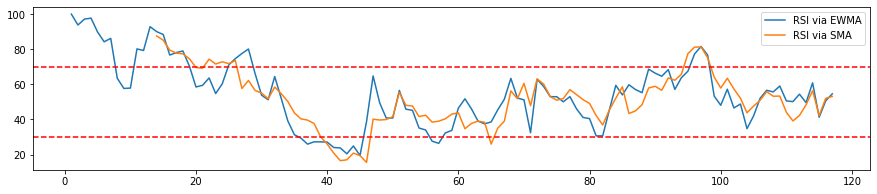

In [8]:
delta = df['CH_CLOSING_PRICE'].diff()

delta = delta[1:] 
window_length = 14
# Make the positive gains (up) and negative gains (down) Series
up, down = delta.clip(lower=0), delta.clip(upper=0)

# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))

# Calculate the SMA
roll_up2 = up.rolling(window_length).mean()
roll_down2 = down.abs().rolling(window_length).mean()

# Calculate the RSI based on SMA
RS2 = roll_up2 / roll_down2
RSI2 = 100.0 - (100.0 / (1.0 + RS2))
df['RSI1'] = RSI1
df['RSI2'] = RSI2
# Compare graphically
plt.figure(figsize=(15, 3))
RSI1.plot()
RSI2.plot()
# plt.plot(df['CH_TIMESTAMP'][1:], RSI1)
# plt.plot(df['CH_TIMESTAMP'][1:], RSI2)
# plt.xticks(rotation = 45)
plt.axhline(30, color='r', linestyle='--')
plt.axhline(70, color='r', linestyle='--')
plt.legend(['RSI via EWMA', 'RSI via SMA'])
plt.show()

In [16]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [17]:
df['RSI'] = computeRSI(df['CH_CLOSING_PRICE'], 14)

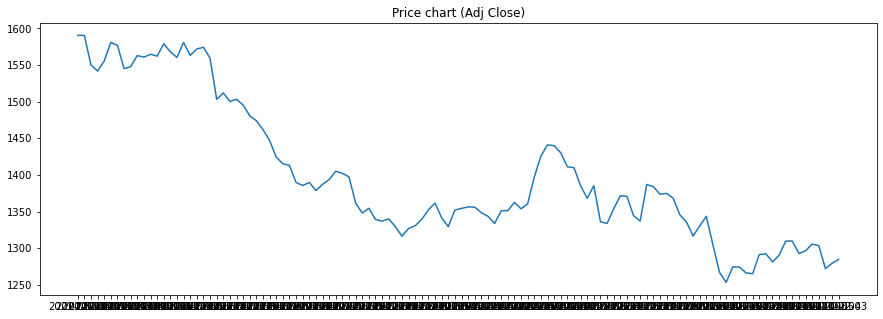

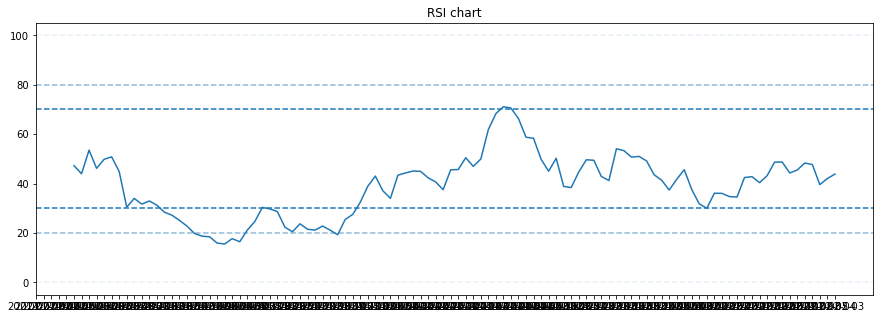

In [18]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(df['CH_TIMESTAMP'], df['CH_CLOSING_PRICE'])
plt.title('Price chart (Adj Close)')
plt.show()

# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.plot(df['CH_TIMESTAMP'], df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1)
plt.axhline(20, linestyle='--', alpha=0.5)
plt.axhline(30, linestyle='--')

plt.axhline(70, linestyle='--')
plt.axhline(80, linestyle='--', alpha=0.5)
plt.axhline(100, linestyle='--', alpha=0.1)
plt.show()

In [23]:
'2021-07-22'

,_id,CH_SYMBOL,CH_SERIES,CH_MARKET_TYPE,CH_TRADE_HIGH_PRICE,CH_TRADE_LOW_PRICE,CH_OPENING_PRICE,CH_CLOSING_PRICE,CH_LAST_TRADED_PRICE,CH_PREVIOUS_CLS_PRICE,...,CH_TOTAL_TRADES,CH_ISIN,CH_TIMESTAMP,TIMESTAMP,createdAt,updatedAt,__v,VWAP,mTIMESTAMP,CA
0,60faaf82874e3300088b1018,INFY,EQ,N,1598.50,1585.05,1588.55,1590.45,1589.00,1590.20,...,144421,INE009A01021,2021-07-23,2021-07-22T18:30:00.000Z,2021-07-23T12:01:06.984Z,2021-07-23T12:01:06.984Z,0,1591.84,23-Jul-2021,NaN
1,60f95e01caa69600097212d2,INFY,EQ,N,1592.85,1561.40,1561.40,1590.20,1588.95,1550.05,...,233651,INE009A01021,2021-07-22,2021-07-21T18:30:00.000Z,2021-07-22T12:01:05.219Z,2021-07-22T12:01:05.219Z,0,1580.70,22-Jul-2021,NaN
2,60f6bae3874e330008167121,INFY,EQ,N,1557.70,1538.00,1538.30,1550.05,1547.00,1541.70,...,138422,INE009A01021,2021-07-20,2021-07-19T18:30:00.000Z,2021-07-20T12:00:35.821Z,2021-07-20T12:00:35.821Z,0,1547.47,20-Jul-2021,NaN
3,60f5695fe089b0000849de05,INFY,EQ,N,1552.90,1537.55,1544.70,1541.70,1544.55,1555.45,...,192818,INE009A01021,2021-07-19,2021-07-18T18:30:00.000Z,2021-07-19T12:00:31.474Z,2021-07-19T12:00:31.474Z,0,1542.32,19-Jul-2021,NaN
4,60f17502cc96fb00089bf5c5,INFY,EQ,N,1574.65,1549.60,1573.75,1555.45,1556.75,1580.80,...,191620,INE009A01021,2021-07-16,2021-07-15T18:30:00.000Z,2021-07-16T12:01:06.616Z,2021-07-16T12:01:06.616Z,0,1560.17,16-Jul-2021,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,5d4427bfaebae50009c21a93,INFY,EQ,N,726.00,715.00,720.80,716.85,716.50,721.05,...,181229,INE009A01021,2019-05-10,2019-05-09T18:30:00.000Z,2019-08-02T12:08:37.141Z,2019-08-02T12:08:37.141Z,0,717.88,10-May-2019,NaN
31,5d4426b8ee5c4800081902ff,INFY,EQ,N,730.30,715.80,719.15,721.05,722.00,719.35,...,242225,INE009A01021,2019-05-09,2019-05-08T18:30:00.000Z,2019-08-02T12:04:29.431Z,2019-08-02T12:04:29.431Z,0,724.48,09-May-2019,NaN
32,5d4423712b7dd50008770e66,INFY,EQ,N,726.00,716.50,721.00,719.35,718.95,724.55,...,162077,INE009A01021,2019-05-08,2019-05-07T18:30:00.000Z,2019-08-02T11:50:55.922Z,2019-08-02T11:50:55.922Z,0,721.65,08-May-2019,NaN
33,5d4426705c8626000828c08b,INFY,EQ,N,727.90,718.70,720.40,724.55,724.40,718.40,...,104342,INE009A01021,2019-05-07,2019-05-06T18:30:00.000Z,2019-08-02T12:02:59.109Z,2019-08-02T12:02:59.109Z,0,724.51,07-May-2019,NaN
